In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

# Process Information Taken from Raw Files

## Import our Previously Extracted Data

In [ ]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)


In [ ]:
subject_dataframes = [] # Initialize our dataframe array

for x in tqdm(record_list): # Extract our dataframes from the CSVs we saved previously
    subject_dataframes.append(pd.read_csv('mit-bih-dataframes/'+x+'.csv', index_col=0))
            # 'index_col=0' loads the index that is saved into the csv as the index rather than another column


In [ ]:

# Now we get the indexes of the R-Peaks from our dataframes
qrs = [] # Initialize the array that will hold our list of R-Peaks for each subject

for subject in tqdm(subject_dataframes): # Load each subject
    qrs.append([idx for idx, x in enumerate(subject['R-Peak']) if x])
    # Then we use list comprehension to get our r peaks for each subject
                                                                # Recall, the indices that the R-Peak column is true is where there is an r-peak
                                                                # So, we iterate through and identify which indices that is for each subject

## Extract RR-Intervals

In 2019, all of our developed variables were based on RR-Intervals, or the distance between adjacent R-Peaks. So, that is the first thing we extract 

In [ ]:
rr_ints = [] # Initialize the array that will hold all of our subjects' RR-Intervals

for idx, subj in enumerate(qrs):
    rr1 = []
    for idxs, r in enumerate(subj):
        if idxs == 0:
            next
        else:
            rr1.append(r-subj[idxs-1])
    rr_ints.append(rr1)
    
# Then we want to Go through all of our data that holds our R-Peaks [That will be the qrs array]
# Iterating through that we want to extract the interval between each peak. 
# My suggested format is: 
"""
for each subject:
    for each rpeak sample_num in my current subject:
        subject_rrinterval.append( rpeak sample_num - the sample_num before it)
"""


## Save the RR-Intervals 

In [ ]:
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .CSV


In [ ]:
rrints_dataframe = []
for idx, x in enumerate(tqdm(record_list)): 
    subj = pd.DataFrame(data=np.transpose(np.array(rr_ints[idx])), columns=["RR Intervals"])
    rrints_dataframe.append(subj)

In [ ]:
reload_flag = False
for idx, x in enumerate(tqdm(record_list)): 
    if not os.path.exists("mit-bih-rrintervals/"+x+".csv") or reload_flag:
        rrints_dataframe[idx].to_csv("mit-bih-rrintervals/"+"subjects"+".csv")
        #np.savetxt("mit-bih-rrintervals/"+x+".csv", np.array(rr_ints[idx]), delimiter=",")

Text(0.5, 1.0, 'RR Intervals For Subjects')

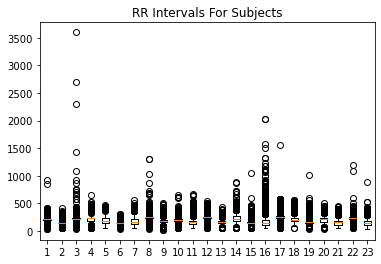

In [121]:
fig, ax = plt.subplots()
ax.boxplot(rr_ints)
ax.set_title('RR Intervals For Subjects')


## What else to extract - some good places to start

- [Moody, 1983 - A new method for detecting atrial fibrillation using R-R intervals.](http://ecg.mit.edu/george/publications/afib-cinc-1983.pdf)
- [Lake, 2010 - Accurate estimation of entropy in very short physiological time series: the problem of atrial fibrillation detection in implanted ventricular devices](https://journals.physiology.org/doi/full/10.1152/ajpheart.00561.2010)
- [Rubio, 2011 - Estudio comparativo de algoritmos para la deteccion de la fibrilacion auricular](https://academica-e.unavarra.es/bitstream/handle/2454/4136/577570.pdf?sequence=1&isAllowed=y)
- [Ghodrati, 2008 - Statistical analysis of RR interval irregularities for detection of atrial fibrillation](https://ieeexplore.ieee.org/document/4749227)
- [Young, 1999 - A comparative study of a hidden Markov model detector for atrial fibrillation](https://ieeexplore.ieee.org/abstract/document/788166)

(array([2.0000e+00, 2.5000e+01, 3.5000e+01, 5.3000e+01, 1.0700e+02,
        1.6100e+02, 2.1500e+02, 2.3500e+02, 2.4100e+02, 3.5600e+02,
        6.7900e+02, 4.6200e+02, 1.7600e+02, 1.1400e+02, 1.4800e+02,
        1.9700e+02, 9.0600e+02, 2.0820e+03, 5.7160e+03, 1.7704e+04,
        8.3030e+03, 3.4950e+03, 2.1260e+03, 1.5800e+02, 2.0000e+01,
        2.4000e+01, 3.4000e+01, 8.0000e+00, 3.0000e+01, 2.7000e+01,
        3.8000e+01, 4.4000e+01, 2.6000e+01, 2.1000e+01, 1.3000e+01,
        7.0000e+00, 2.0000e+00, 5.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

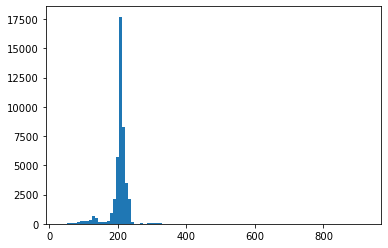

In [112]:
plt.hist(rr_ints[0], bins=100)

In [ ]:

for idx, x in enumerate(tqdm(subject_dataframes[0]['Normal']):
    if x:
        plt.axvline(idx, color = 'green', alpha = .05, label = 'Normal Rhythm')
for idx, x in enumerate(tqdm(subject_dataframes[0]['AFIB'])):
    if x:
        plt.axvline(idx, color = 'red', alpha = .05, label = 'AFIB Rhythm')
for idx, x in enumerate(tqdm(subject_dataframes[0]['Other'])):
    if x:
        plt.axvline(idx, color = 'green', alpha = .05, label = 'Normal Rhythm')
plt.plot(rr_ints[0])

In [103]:
df_allcolors=[]
for idx, subj in enumerate(tqdm(qrs)):
    df_color=[]
    for x in subj:
        if subject_dataframes[idx].loc[x, 'Normal']:
            df_color.append('green')
        elif subject_dataframes[idx].loc[x, 'AFIB']:
            df_color.append('red')
        else:
            df_color.append('orange')
    df_allcolors.append(df_color)
    
    



100%|██████████| 23/23 [01:16<00:00,  3.35s/it]


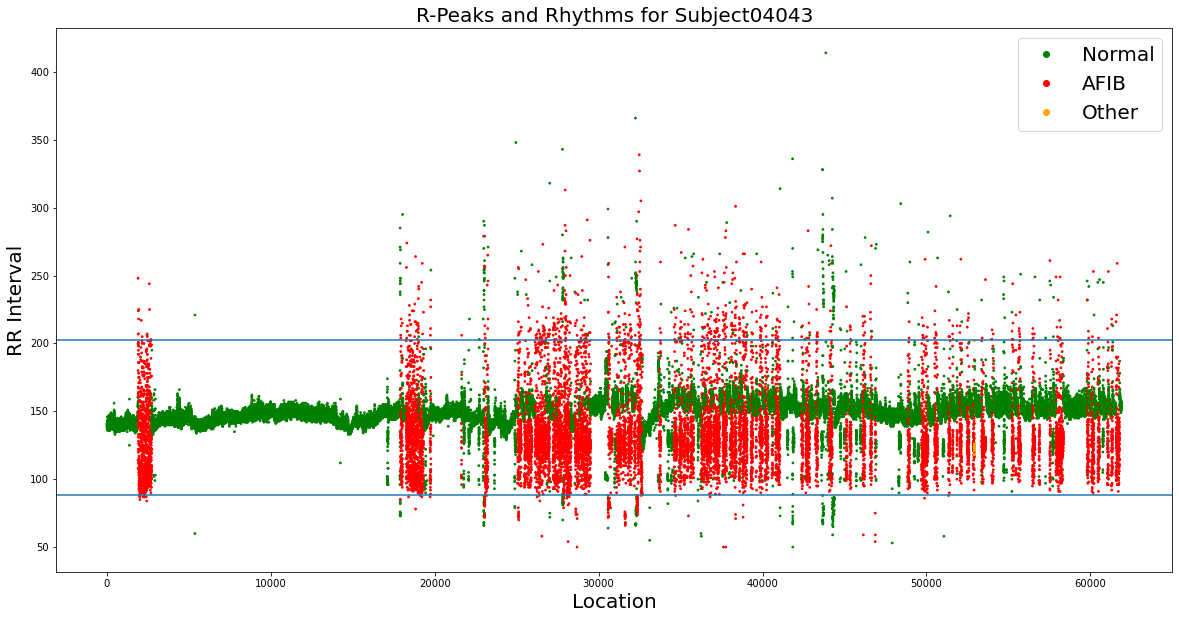

In [118]:
subj_number=1

plt.figure(figsize=(20, 10))
plt.scatter(range(len(rr_ints[subj_number])), rr_ints[subj_number], color=df_allcolors[subj_number][1:], s=3)


legenddict = {
    'Normal': 'green',
    'AFIB': 'red',
    'Other': 'orange'
}

handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for color in legenddict.values()]
plt.legend(handlelist, legenddict.keys(), prop={"size": 20})
plt.title('R-Peaks and Rhythms for Subject' + str(record_list[subj_number]), fontsize=20)
plt.ylabel('RR Interval', fontsize=20)
plt.xlabel('Location', fontsize=20)
plt.axhline(np.mean(rr_ints[subj_number]) + 3*np.std(rr_ints[subj_number]))
plt.axhline(np.mean(rr_ints[subj_number]) - 3*np.std(rr_ints[subj_number]))


#Code taken from following link: https://stackoverflow.com/questions/42180475/how-to-add-legend-to-scatter-plot-that-has-colour-assignment

In [113]:
new_rrints = []
for subj in rr_ints:
    new_rrints.append([x for x in subj if x < 500])
    

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.500e+01, 1.400e+01, 1.200e+01,
        1.900e+01, 2.000e+01, 2.000e+01, 3.700e+01, 3.400e+01, 6.200e+01,
        4.700e+01, 8.100e+01, 8.800e+01, 9.400e+01, 7.400e+01, 9.200e+01,
        1.220e+02, 1.170e+02, 9.100e+01, 1.430e+02, 1.490e+02, 2.220e+02,
        2.250e+02, 3.290e+02, 2.360e+02, 1.930e+02, 1.130e+02, 5.200e+01,
        5.900e+01, 5.200e+01, 4.700e+01, 4.400e+01, 6.500e+01, 7.700e+01,
        8.900e+01, 7.000e+01, 3.590e+02, 5.470e+02, 6.310e+02, 8.890e+02,
        1.156e+03, 2.040e+03, 4.527e+03, 5.497e+03, 8.972e+03, 5.699e+03,
        3.174e+03, 1.727e+03, 1.534e+03, 1.454e+03, 1.384e+03, 6.630e+02,
        1.510e+02, 6.800e+01, 2.300e+01, 8.000e+00, 7.000e+00, 1.000e+01,
        1.300e+01, 1.100e+01, 1.500e+01, 9.000e+00, 7.000e+00, 1.000e+00,
        6.000e+00, 1.600e+01, 1.000e+01, 1.400e+01, 1.100e+01, 2.000e+01,
        1.200e+01, 1.800e+01, 1.800e+01, 1.500e+01, 1.300e+01, 1.200e+01,
        1.600e+01, 3.000e+00, 3.000e+0

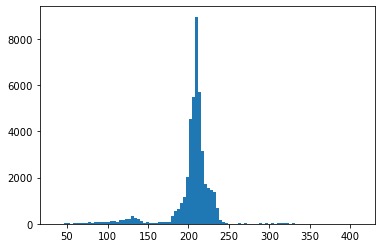

In [110]:
plt.hist(new_rrints[0], bins=100)

In [ ]:
rhythm_dics = []
header_dics = []

for x in record_list:
    with open('mit-bih-extracted/'+x+'_rhythms.pkl', mode='rb') as infile:
        rhythm_dics.append(pickle.load(infile))
    with open('mit-bih-extracted/'+x+'_headers.pkl', mode='rb') as infile:
        header_dics.append(pickle.load(infile))